### Time Series Changes and Versioning with TimeDB

This notebook demonstrates how to manually change values, tags, and annotations of a time series and view all versions of the changes.

#### What you'll learn:
1. **Creating and inserting time series** - Insert flat series + overlapping series with TWO batches
2. **Reading and visualizing time series** - Read latest and all versions
3. **Updating flat series** - In-place updates for fact data (no versioning)
4. **Updating overlapping series** - Versioned updates with multiple lookup methods
5. **Flexible update lookups** - Using `batch_id`, `known_time`, or just `valid_time`
6. **Reading all versions** - Query all versions using `versions=True`
7. **Visualizing changes** - Plot Batch 1 vs Batch 2 vs Updates

**Key Concepts:**
- **Flat series**: In-place updates (no versioning) - good for correcting fact data
- **Overlapping series**: Versioned updates via `known_time` - maintains full audit trail
- **Multiple batches**: Each batch insert creates a new version per valid_time
- For overlapping updates, you can identify the version to update using:
  - `known_time + valid_time`: Exact version lookup
  - `batch_id + valid_time`: Latest version in that batch
  - Just `valid_time`: Latest version overall (most convenient)
- Updates can modify values, annotations, and tags independently or together

In [1]:
from timedb import TimeDataClient
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import numpy as np
from dotenv import load_dotenv
load_dotenv()

td = TimeDataClient()
td.delete()
td.create()

Creating database schema...
✓ Schema created successfully


## Part 1: Insert Time Series (Flat and Overlapping)

First, let's insert two time series:
- **Flat series**: `meter_reading` - for fact data that can be corrected in-place
- **Overlapping series**: `temperature` - for estimates/forecasts with version history

For the overlapping series, we'll insert **TWO batches** to demonstrate versioning:
- **Batch 1**: Initial forecast (known_time = 00:00)
- **Batch 2**: Revised forecast (known_time = 02:00) with slightly different values

This means each valid_time will have 2 versions before we even start updating!

In [2]:
# Create time series with hourly data for 24 hours
base_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
times = [base_time + timedelta(hours=i) for i in range(24)]

# Generate sample data
np.random.seed(42)

# Temperature values with a daily pattern (for overlapping series)
base_temp = 20.0
amplitude = 5.0
temperature_values = [
    base_temp + amplitude * np.sin(2 * np.pi * i / 24) + np.random.normal(0, 0.5)
    for i in range(24)
]
temperature_values = [round(v, 2) for v in temperature_values]

# Meter readings (for flat series)
meter_values = [100.0 + i * 5.0 + np.random.normal(0, 0.2) for i in range(24)]
meter_values = [round(v, 2) for v in meter_values]

# Create DataFrames
df_temp = pd.DataFrame({'valid_time': times, 'temperature': temperature_values})
df_meter = pd.DataFrame({'valid_time': times, 'meter_reading': meter_values})

# Create the series
# Flat: for fact data (meter readings) - in-place updates
if td.series("meter_reading").count() == 0:
    td.create_series(name="meter_reading", unit="dimensionless", data_class="flat")

# Overlapping: for estimates (temperature) - versioned updates
if td.series("temperature").count() == 0:
    td.create_series(name="temperature", unit="dimensionless", data_class="overlapping")

# Insert the flat series (no known_time needed)
result_flat = td.series("meter_reading").insert(df=df_meter)
print(f"Inserted FLAT series: meter_reading")
print(f"  Series ID: {result_flat.series_ids['meter_reading']}")

# ============================================================================
# Insert TWO batches for overlapping series to demonstrate versioning
# ============================================================================

# Batch 1: Initial forecast made at base_time
known_time_1 = base_time
result_batch_1 = td.series("temperature").insert(df=df_temp, known_time=known_time_1)
print(f"\nInserted OVERLAPPING Batch 1 (initial forecast):")
print(f"  Batch ID: {result_batch_1.batch_id}")
print(f"  Known time: {known_time_1}")

# Batch 2: Revised forecast made 2 hours later (with slightly different values)
known_time_2 = base_time + timedelta(hours=2)
temperature_values_revised = [v + np.random.normal(0, 1.0) for v in temperature_values]
temperature_values_revised = [round(v, 2) for v in temperature_values_revised]
df_temp_revised = pd.DataFrame({'valid_time': times, 'temperature': temperature_values_revised})

result_batch_2 = td.series("temperature").insert(df=df_temp_revised, known_time=known_time_2)
print(f"\nInserted OVERLAPPING Batch 2 (revised forecast):")
print(f"  Batch ID: {result_batch_2.batch_id}")
print(f"  Known time: {known_time_2}")

# Store IDs for later use
batch_id_1 = result_batch_1.batch_id
batch_id_2 = result_batch_2.batch_id
series_id_temp = result_batch_1.series_ids['temperature']
series_id_meter = result_flat.series_ids['meter_reading']

print(f"\n" + "=" * 60)
print("Now we have TWO versions for each valid_time in the overlapping series!")
print("  - Batch 1 (known_time={known_time_1}): original forecast")
print("  - Batch 2 (known_time={known_time_2}): revised forecast")
print("=" * 60)

Inserted FLAT series: meter_reading
  Series ID: 1

Inserted OVERLAPPING Batch 1 (initial forecast):
  Batch ID: 2
  Known time: 2025-01-01 00:00:00+00:00

Inserted OVERLAPPING Batch 2 (revised forecast):
  Batch ID: 3
  Known time: 2025-01-01 02:00:00+00:00

Now we have TWO versions for each valid_time in the overlapping series!
  - Batch 1 (known_time={known_time_1}): original forecast
  - Batch 2 (known_time={known_time_2}): revised forecast


## Part 2: Read and Plot the Time Series

Let's read back both time series and visualize them.

For the overlapping series, `read()` returns the **latest version** (highest `known_time`), which is Batch 2.
Use `read(versions=True)` to see all versions.

In [3]:
# Read both time series
# For overlapping, read() returns the LATEST version (highest known_time)
df_temp_read = td.series("temperature").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
)

df_meter_read = td.series("meter_reading").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
)

print(f"Temperature (overlapping, latest version): {len(df_temp_read)} data points")
print(f"Meter reading (flat): {len(df_meter_read)} data points")

# Also read ALL versions to see both batches
df_temp_all_versions = td.series("temperature").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
    versions=True,  # Get ALL versions
)

print(f"\nTemperature (all versions): {len(df_temp_all_versions)} data points")
print(f"  (24 hours x 2 batches = 48 rows)")
print(f"\nIndex levels: {df_temp_all_versions.index.names}")

# Show a sample of the multi-version data
print("\nSample of all versions (first 6 rows):")
df_temp_all_versions.head(6)

Temperature (overlapping, latest version): 24 data points
Meter reading (flat): 24 data points

Temperature (all versions): 48 data points
  (24 hours x 2 batches = 48 rows)

Index levels: ['known_time', 'valid_time']

Sample of all versions (first 6 rows):


name                                                 temperature
known_time                valid_time                            
2025-01-01 00:00:00+00:00 2025-01-01 00:00:00+00:00        20.25
                          2025-01-01 01:00:00+00:00        21.22
                          2025-01-01 02:00:00+00:00        22.82
                          2025-01-01 03:00:00+00:00         24.3
                          2025-01-01 04:00:00+00:00        24.21
                          2025-01-01 05:00:00+00:00        24.71

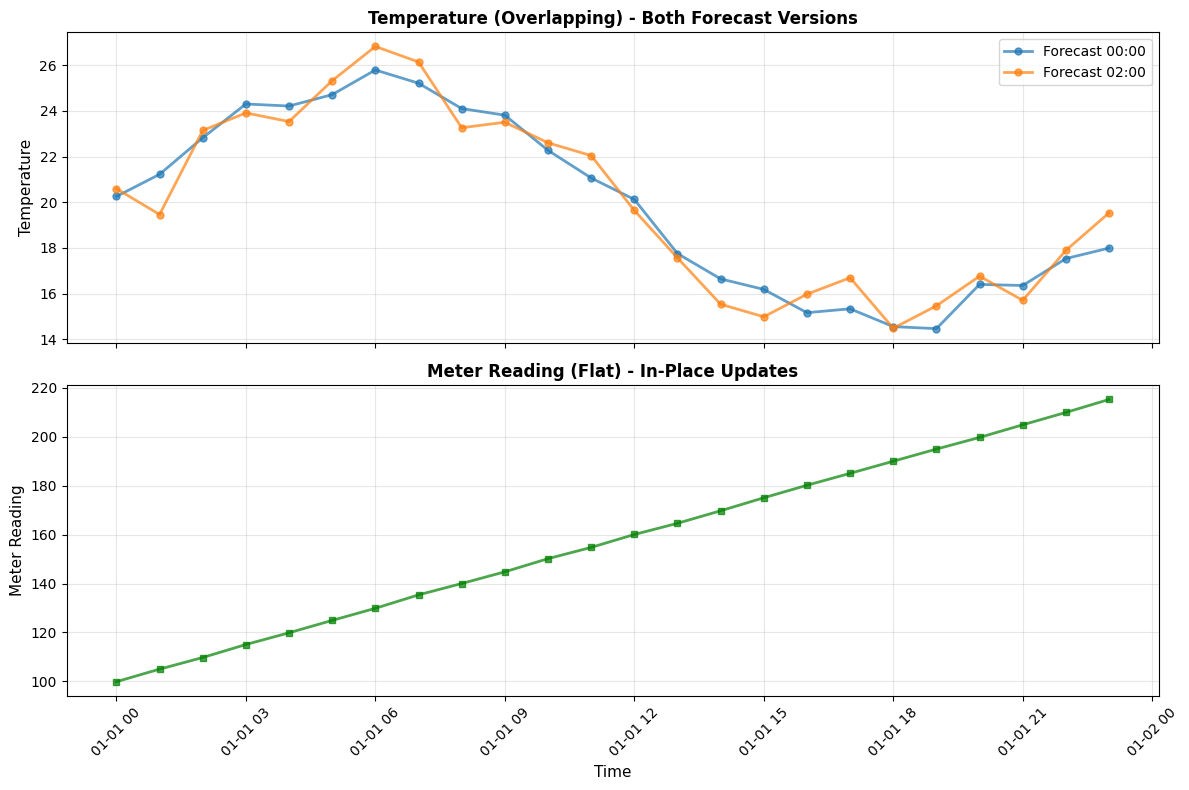

✓ Both time series plotted successfully!


In [4]:
# Plot both time series
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Temperature (overlapping series) - show BOTH forecasts
ax1 = axes[0]

# Get both versions from df_temp_all_versions
for known_time in df_temp_all_versions.index.get_level_values('known_time').unique():
    df_version = df_temp_all_versions.xs(known_time, level='known_time')
    temp_y = df_version['temperature'].astype(float)
    label = f"Forecast {known_time.strftime('%H:%M')}"
    ax1.plot(df_version.index.get_level_values('valid_time'), temp_y, 
             marker='o', linewidth=2, markersize=5, alpha=0.7, label=label)

ax1.set_ylabel('Temperature', fontsize=11)
ax1.set_title('Temperature (Overlapping) - Both Forecast Versions', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Meter reading (flat series)
ax2 = axes[1]
meter_y = df_meter_read['meter_reading'].astype(float)
ax2.plot(df_meter_read.index, meter_y, marker='s', linewidth=2, markersize=5, 
         color='green', alpha=0.7)
ax2.set_ylabel('Meter Reading', fontsize=11)
ax2.set_xlabel('Time', fontsize=11)
ax2.set_title('Meter Reading (Flat) - In-Place Updates', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✓ Both time series plotted successfully!")

## Part 3: Update a Flat Series (In-Place)

Flat series use **in-place updates** - there's no version history. The value is simply replaced.

This is ideal for correcting fact data like meter readings where you want to fix errors without maintaining a version trail.

In [5]:
# Update a flat series - simple, no batch_id needed!
update_time_flat = base_time + timedelta(hours=5)

# Read current value
original_meter_value = float(df_meter_read.loc[update_time_flat, 'meter_reading'])
print(f"Original meter reading at {update_time_flat}: {original_meter_value:.2f}")

# Update the flat series - just need series_id and valid_time!
corrected_meter_value = 130.0

result = td.series("meter_reading").update_records(updates=[{
    "valid_time": update_time_flat,
    "value": corrected_meter_value,
    "annotation": "Corrected: faulty meter reading",
    "changed_by": "technician@example.com",
}])

print(f"\nFlat update completed!")
print(f"  Updated: {original_meter_value:.2f} -> {corrected_meter_value:.2f}")
print(f"  Updated records: {len(result['updated'])}")
print(f"  Skipped (no-op): {len(result['skipped_no_ops'])}")

# Verify the update - read it back
df_meter_after = td.series("meter_reading").read(
    start_valid=update_time_flat,
    end_valid=update_time_flat + timedelta(hours=1),
)
print(f"\nVerification - current value: {float(df_meter_after.iloc[0]['meter_reading']):.2f}")

Original meter reading at 2025-01-01 05:00:00+00:00: 124.94

Flat update completed!
  Updated: 124.94 -> 130.00
  Updated records: 1
  Skipped (no-op): 0

Verification - current value: 130.00


## Part 4: Update Overlapping Series (Versioned)

Overlapping series create **new versions** on each update - the old value is preserved with its original `known_time`.

Since we now have **two batches** (two versions per valid_time), we can demonstrate three ways to identify which version to update:

1. **Using `batch_id`**: Target the latest version within a specific batch
2. **Using `known_time`**: Target an exact version by its known_time  
3. **Using just `valid_time`**: Target the latest version overall (most convenient!)

In [6]:
# We'll update three different time points using each method
update_time_1 = base_time + timedelta(hours=6)   # Method 1: batch_id (target batch 1)
update_time_2 = base_time + timedelta(hours=12)  # Method 2: known_time (target batch 1's version)
update_time_3 = base_time + timedelta(hours=18)  # Method 3: just valid_time (target latest = batch 2)

# First, let's see what values we have for these times across both batches
print("Current values BEFORE updates:")
print("=" * 70)
for ut in [update_time_1, update_time_2, update_time_3]:
    versions = df_temp_all_versions.xs(ut, level='valid_time')
    print(f"\nValid time: {ut}")
    for known_time, row in versions.iterrows():
        kt = known_time if not isinstance(known_time, tuple) else known_time[0]
        print(f"  known_time={kt}: {float(row['temperature']):.2f}")

print("\n" + "=" * 70)
print("METHOD 1: Update using batch_id (targeting Batch 1)")
print("=" * 70)
print(f"We'll update the value at {update_time_1} in Batch 1 specifically")

result_1 = td.update_records(updates=[{
    "batch_id": batch_id_1,  # Target Batch 1
    "valid_time": update_time_1,
    "series_id": series_id_temp,
    "value": 29.0,
    "annotation": "Updated via batch_id (targeting Batch 1)",
    "tags": ["method_batch_id"],
    "changed_by": "demo@example.com",
}])
print(f"✓ Updated: {len(result_1['updated'])} records")
print(f"  This creates a NEW version (known_time=now()) based on Batch 1's value")

print("\n" + "=" * 70)
print("METHOD 2: Update using known_time (exact version lookup)")
print("=" * 70)
print(f"We'll update the value at {update_time_2} from Batch 1 (known_time={known_time_1})")

result_2 = td.update_records(updates=[{
    "known_time": known_time_1,  # Target the exact version from Batch 1
    "valid_time": update_time_2,
    "series_id": series_id_temp,
    "value": 27.0,
    "annotation": "Updated via known_time (exact version from Batch 1)",
    "tags": ["method_known_time"],
    "changed_by": "demo@example.com",
}])
print(f"✓ Updated: {len(result_2['updated'])} records")
print(f"  This targets the EXACT version with known_time={known_time_1}")

print("\n" + "=" * 70)
print("METHOD 3: Update using just valid_time (latest version)")
print("=" * 70)
print(f"We'll update the LATEST version at {update_time_3}")
print(f"(The latest is from Batch 2, known_time={known_time_2})")

result_3 = td.series("temperature").update_records(updates=[{
    "valid_time": update_time_3,  # Just valid_time - finds latest!
    "value": 25.0,
    "annotation": "Updated via latest lookup (most convenient!)",
    "tags": ["method_latest"],
    "changed_by": "demo@example.com",
}])
print(f"✓ Updated: {len(result_3['updated'])} records")
print(f"  This is the simplest - just provide valid_time and it finds the latest")

Current values BEFORE updates:

Valid time: 2025-01-01 06:00:00+00:00
  known_time=2025-01-01 00:00:00+00:00: 25.79
  known_time=2025-01-01 02:00:00+00:00: 26.82

Valid time: 2025-01-01 12:00:00+00:00
  known_time=2025-01-01 00:00:00+00:00: 20.12
  known_time=2025-01-01 02:00:00+00:00: 19.64

Valid time: 2025-01-01 18:00:00+00:00
  known_time=2025-01-01 00:00:00+00:00: 14.55
  known_time=2025-01-01 02:00:00+00:00: 14.48

METHOD 1: Update using batch_id (targeting Batch 1)
We'll update the value at 2025-01-01 06:00:00+00:00 in Batch 1 specifically
✓ Updated: 1 records
  This creates a NEW version (known_time=now()) based on Batch 1's value

METHOD 2: Update using known_time (exact version lookup)
We'll update the value at 2025-01-01 12:00:00+00:00 from Batch 1 (known_time=2025-01-01 00:00:00+00:00)
✓ Updated: 1 records
  This targets the EXACT version with known_time=2025-01-01 00:00:00+00:00

METHOD 3: Update using just valid_time (latest version)
We'll update the LATEST version at 202

## Part 5: View All Versions (Version History)

Now let's read the overlapping series with `versions=True` to see all versions:
- Original Batch 1 values
- Revised Batch 2 values  
- Our new update versions (with `known_time=now()`)

In [7]:
# Read all versions for the time points we updated
df_versions = td.series("temperature").read(
    start_valid=base_time + timedelta(hours=5),
    end_valid=base_time + timedelta(hours=20),
    versions=True,  # Get ALL versions, not just latest
)

print("All versions AFTER updates:")
print("=" * 80)

# Show versions for each updated time point
for ut, method in [(update_time_1, 'batch_id'), (update_time_2, 'known_time'), (update_time_3, 'valid_time')]:
    print(f"\nValid time: {ut} (updated via {method})")
    print("-" * 60)
    
    try:
        versions = df_versions.xs(ut, level='valid_time')
        for idx, row in versions.iterrows():
            known_time = idx if not isinstance(idx, tuple) else idx[0]
            value = float(row['temperature'])
            # Identify which batch/update this is from
            if known_time == known_time_1:
                source = "Batch 1 (original)"
            elif known_time == known_time_2:
                source = "Batch 2 (revised)"
            else:
                source = "UPDATE (new version)"
            print(f"  known_time: {known_time} -> value: {value:.2f}  [{source}]")
    except KeyError:
        print(f"  No data for this time point")

print("\n" + "=" * 80)
print("Key insight: Each update created a NEW version with known_time=now().")
print("The original Batch 1 and Batch 2 values are still preserved!")
print("=" * 80)

All versions AFTER updates:

Valid time: 2025-01-01 06:00:00+00:00 (updated via batch_id)
------------------------------------------------------------
  known_time: 2025-01-01 00:00:00+00:00 -> value: 25.79  [Batch 1 (original)]
  known_time: 2025-01-01 02:00:00+00:00 -> value: 26.82  [Batch 2 (revised)]
  known_time: 2026-02-11 13:24:59.980601+00:00 -> value: 29.00  [UPDATE (new version)]

Valid time: 2025-01-01 12:00:00+00:00 (updated via known_time)
------------------------------------------------------------
  known_time: 2025-01-01 00:00:00+00:00 -> value: 20.12  [Batch 1 (original)]
  known_time: 2025-01-01 02:00:00+00:00 -> value: 19.64  [Batch 2 (revised)]
  known_time: 2026-02-11 13:25:00.087528+00:00 -> value: 27.00  [UPDATE (new version)]

Valid time: 2025-01-01 18:00:00+00:00 (updated via valid_time)
------------------------------------------------------------
  known_time: 2025-01-01 00:00:00+00:00 -> value: 14.55  [Batch 1 (original)]
  known_time: 2025-01-01 02:00:00+00:

## Part 6: Visualize Original vs Updated

Let's plot both versions to see the changes visually.

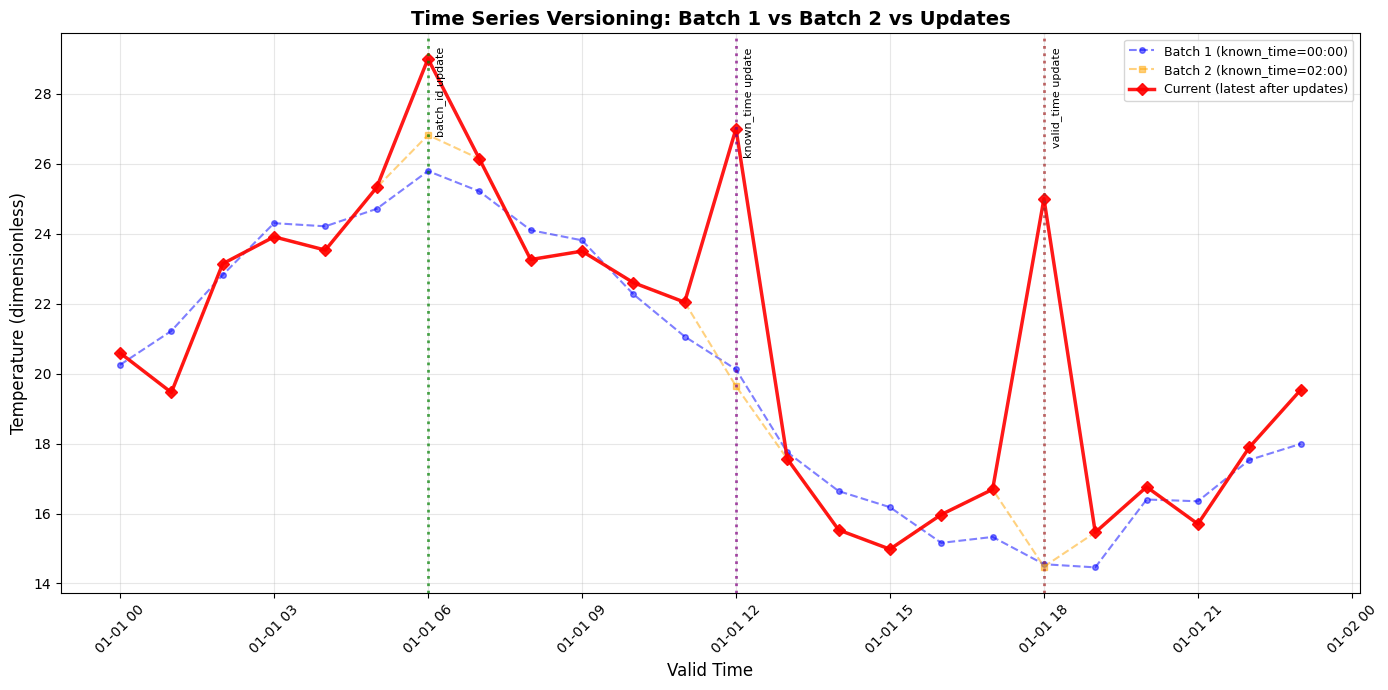

Dotted lines mark the three updated time points (hours 6, 12, 18)


In [8]:
# Read current (latest) version after all updates
df_current = td.series("temperature").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
)

# Also read Batch 1 and Batch 2 values for comparison
# We can get them by reading all versions and filtering
df_all = td.series("temperature").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
    versions=True,
)

# Plot comparison
plt.figure(figsize=(14, 7))

# Extract values from each batch
batch1_values = []
batch2_values = []
for vt in times:
    try:
        versions = df_all.xs(vt, level='valid_time')
        for kt, row in versions.iterrows():
            known_time = kt if not isinstance(kt, tuple) else kt[0]
            if known_time == known_time_1:
                batch1_values.append(float(row['temperature']))
            elif known_time == known_time_2:
                batch2_values.append(float(row['temperature']))
    except KeyError:
        pass

# Plot Batch 1 (original)
plt.plot(times, batch1_values, 
         marker='o', linewidth=1.5, markersize=4, 
         label=f'Batch 1 (known_time={known_time_1.strftime("%H:%M")})', 
         color='blue', alpha=0.5, linestyle='--')

# Plot Batch 2 (revised)
plt.plot(times, batch2_values, 
         marker='s', linewidth=1.5, markersize=4, 
         label=f'Batch 2 (known_time={known_time_2.strftime("%H:%M")})', 
         color='orange', alpha=0.5, linestyle='--')

# Plot current (latest after updates)
current_y = df_current['temperature'].astype(float)
plt.plot(df_current.index, current_y, 
         marker='D', linewidth=2.5, markersize=6, 
         label='Current (latest after updates)', color='red', alpha=0.9)

# Highlight the updated points
for ut, label, color in [
    (update_time_1, 'batch_id update', 'green'),
    (update_time_2, 'known_time update', 'purple'),
    (update_time_3, 'valid_time update', 'brown')
]:
    plt.axvline(x=ut, color=color, linestyle=':', linewidth=2, alpha=0.7)
    # Add annotation
    plt.annotate(label, xy=(ut, plt.ylim()[1]), xytext=(5, -10),
                 textcoords='offset points', fontsize=8, rotation=90, va='top')

plt.xlabel('Valid Time', fontsize=12)
plt.ylabel('Temperature (dimensionless)', fontsize=12)
plt.title('Time Series Versioning: Batch 1 vs Batch 2 vs Updates', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Dotted lines mark the three updated time points (hours 6, 12, 18)")

## Part 7: Compare Update Methods

Let's look at the version history in detail to see how each method created a new version.

In [9]:
# Get detailed version count for the updated time points
print("Version count per valid_time:")
print("=" * 80)

for ut, method in [(update_time_1, 'batch_id'), (update_time_2, 'known_time'), (update_time_3, 'valid_time')]:
    try:
        versions = df_versions.xs(ut, level='valid_time')
        num_versions = len(versions)
        print(f"\nValid time: {ut}")
        print(f"  Updated via: {method}")
        print(f"  Total versions: {num_versions}")
        print(f"  Breakdown:")
        for idx, row in versions.iterrows():
            known_time = idx if not isinstance(idx, tuple) else idx[0]
            value = float(row['temperature'])
            if known_time == known_time_1:
                print(f"    - Batch 1 (original):  {value:.2f}")
            elif known_time == known_time_2:
                print(f"    - Batch 2 (revised):   {value:.2f}")
            else:
                print(f"    - Update (latest):     {value:.2f}  <-- current")
    except KeyError:
        print(f"  No data")

print("\n" + "=" * 80)
print("\nWhen you call read() without versions=True, you get the 'current' value")
print("(the one with the highest known_time for each valid_time).")
print("\nWith versions=True, you see the complete audit trail of all changes.")

Version count per valid_time:

Valid time: 2025-01-01 06:00:00+00:00
  Updated via: batch_id
  Total versions: 3
  Breakdown:
    - Batch 1 (original):  25.79
    - Batch 2 (revised):   26.82
    - Update (latest):     29.00  <-- current

Valid time: 2025-01-01 12:00:00+00:00
  Updated via: known_time
  Total versions: 3
  Breakdown:
    - Batch 1 (original):  20.12
    - Batch 2 (revised):   19.64
    - Update (latest):     27.00  <-- current

Valid time: 2025-01-01 18:00:00+00:00
  Updated via: valid_time
  Total versions: 3
  Breakdown:
    - Batch 1 (original):  14.55
    - Batch 2 (revised):   14.48
    - Update (latest):     25.00  <-- current


When you call read() without versions=True, you get the 'current' value
(the one with the highest known_time for each valid_time).

With versions=True, you see the complete audit trail of all changes.


## Summary

This notebook demonstrated time series versioning with TimeDB.

### Setup: Two Initial Batches
We inserted two forecast batches to demonstrate versioning:
- **Batch 1** (known_time=00:00): Original forecast
- **Batch 2** (known_time=02:00): Revised forecast

This means each valid_time already has 2 versions before any updates!

### Flat Series Updates (In-Place)
- **Simple key**: Just `(series_id, valid_time)` - no batch_id needed
- **Behavior**: In-place modification (no version history)
- **Use case**: Correcting fact data like meter readings

```python
td.series("meter").update_records(updates=[{
    "valid_time": dt,
    "value": 150.0,
    "annotation": "Corrected reading",
}])
```

### Overlapping Series Updates (Versioned)
Three ways to identify which version to update:

**1. Using `batch_id`** - Target a specific batch:
```python
td.update_records(updates=[{
    "batch_id": batch_id_1,  # Target Batch 1
    "valid_time": dt,
    "series_id": series_id,
    "value": 99.0,
}])
```

**2. Using `known_time`** - Target an exact version:
```python
td.update_records(updates=[{
    "known_time": known_time_1,  # Exact version
    "valid_time": dt,
    "series_id": series_id,
    "value": 88.0,
}])
```

**3. Using just `valid_time`** - Target latest version overall (most convenient!):
```python
td.series("temperature").update_records(updates=[{
    "valid_time": dt,  # That's it!
    "value": 77.0,
}])
```

### Key Takeaways
- **Flat series**: In-place updates, no versioning
- **Overlapping series**: Versioned updates, creates new row with `known_time=now()`
- **Multiple batches**: Each batch creates a new version per valid_time
- **Flexible lookups**: Use `batch_id`, `known_time`, or just `valid_time` for overlapping
- **Read versions**: Use `read(versions=True)` to see complete audit trail
- **Updateable fields**: `value`, `annotation`, `tags`, `changed_by`